# Final project -- Numerical Analysis -- 2020/2021

## General goal

Consider the hyper-cube $\Omega := [-1,1]^d$ in dimension `d`.

Given a function $f: \Omega \mapsto R$, find $u: \Omega \mapsto R$ such that 

$
- \Delta u  + u = f, \text{ in } \Omega
$

$
\frac{\partial u}{\partial n} = 0 \text{ on } \partial \Omega
$

using Chebyshev spectral elements, and in a matrix-free framework.

## Due date: 

- MHPC students: 20 February 2021
- DSSC/LM/PHD students: 1 day before the oral examination

## General definitions

We recall here some general definitions that will be useful throughout the project.

- The space $Q^p(\Omega)$ is the space of polynomials of order $p$ in each coordinate direction. The dimension of $Q^p$ is $(p+1)^d$ where $d$ is the dimension of the space. 

- A tensor product basis for $Q^p(\Omega)$ can be constructed from a basis for $P^p([-1,1])$, by arranging the indices in d-dimensional arrays, i.e., if $\{v_i\}_{i=0}^p$ is a basis for $P^p([-1,1])$, then, for example, 
$
v_{ijk} := v_i(x_0)v_j(x_1)v_k(x_2)
$
is a basis for $Q^p([-1,1]^3)$.

- Chebyshev points of type 2 are Chebishev points in one dimension that include end points. These are not minimizers of the linfty norm of the Lebesgue function (those are Chebishev points of type 1), but are minimizers of Lebesgue function when you constrain two of the points to coincide with the extremes of the interval $[-1,1]$. You can obtain those points by calling `numpy.polynomial.chebyshev.chebpts2`.

- Chebyshev spectral elements are the tensor product basis for $Q^p(\Omega)$, generated by the Lagrange basis functions constructed using as support points the Chebyshev points of type 2. In one dimension, for degree=5, npoints=6, they look like

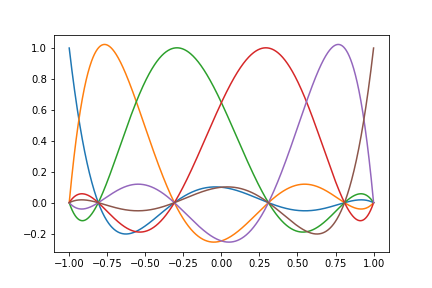

- Integration in each coordinate direction can be performed using Gauss quadrature formulas, which can be queried by the function `numpy.polynomial.legendre.leggauss`. That function returns a tuple of two objects,  containing both the quadrature points `q` and the quadrature weights `w`, i.e., `q, w = numpy.polynomial.legendre.leggauss(nq)`.

- The construction of a Lagrange basis can be done easily by calling `scipy.interpolate.lagrange(X, ei)` where `X` are the interpolation points, and `ei` is a vector containing all zeros, except a one in the position corresponding to the index i. For example, the following code 

~~~
X = numpy.polynomial.chebyshev.chebpts2(6)
e_3 = zeros((6,))
e_3[3] = 1

B_3 = lagrange(X, e_3)
B_3_prime = polyder(B_3)

x = linspace(-1,1,501)
plot(x, B_3(x))
plot(X, 0*X, 'ro')
figure()
plot(x, B_3_prime(x))
plot(X, 0*X, 'ro')
~~~

will produce the following pictures

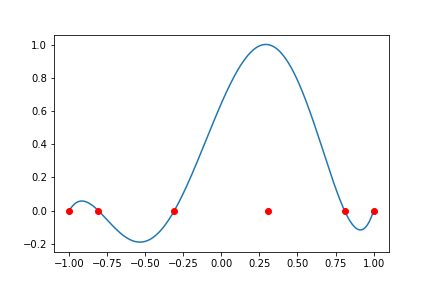

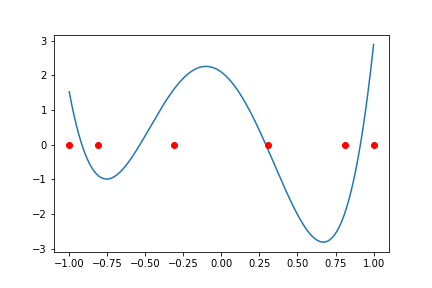

Which correspond to the fourth (`index=3`) Chebishev spectral basis function and its derivative, for the space $P^5([-1,1])$.

The functions `B_3` and `B_3_prime` computed above are callable functions, i.e., you can evaluate the basis and its derivative as normal functions, and they accept as input numpy arrays.

## Weak formulation

The weak form of the problem reads:

Given $f:\Omega \mapsto R$, find $u\in H^1(\Omega)$ such that

$
\int_\Omega \nabla u \cdot \nabla v + \int_\Omega u v = \int_\Omega f v \qquad \forall v \in H^1(\Omega)
$

## Discrete weak formulation (one dimensional case)

Given a finite dimensional space $V_h \subset H^1([-1,1])$ such that  $V_h = \text{span}\{v_i\}_{i=0}^p$, then
the discrete problem reads:

Find $u$ such that

$
A u = f 
$

where $A$ is a matrix in  $R^{(p+1)\times(p+1)}$  and $f$ is a vector in $R^{(p+1)}$ 

$
A_{ij} = \int_\Omega \nabla v_j \cdot \nabla v_i+\int_\Omega  v_j  v_i, \qquad f_i = \int_\Omega f v_i
$

that is (using a quadrature with $q_\alpha$ and $w_\alpha$ as points and weights):

$
A_{ij} = \sum_{\alpha=0}^{nq-1}\left( v'_j(q_\alpha) v'_i(q_\alpha)+  v_j(q_\alpha)  v_i(q_\alpha)\right)w_\alpha
$

$
f_{i} = \sum_{\alpha=0}^{nq-1} v_j(q_\alpha) f(q_\alpha) w_\alpha
$

Let's assume we have computed the matrices $B_{i\alpha} := v_i(q_\alpha)$, and $D_{i\alpha} := v'_i(q_\alpha)$ containing the evaluation of all basis functions and of their derivatives in the quadrature points $q_\alpha$.  

The matrix $A$ can then be written as

$
A_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha + B_{i\alpha} B_{j\alpha} w_\alpha\right) = K_{ij} + M_{ij}
$

where $K$ is usually known as the one dimensional stiffness matrix, and $M$ as the one dimensional mass matrix:


$
K_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha \right)
$


$
M_{ij} = \sum_\alpha \left(B_{i\alpha} B_{j\alpha} w_\alpha \right)
$

Using numpy and Lapack, these can be computed efficiently by calling `einsum`:

~~~
K = einsum('iq, q, jq', D, w, D)
M = einsum('iq, q, jq', B, w, B)
~~~

where the function `einsum` interprets the first argument (a string) as a list of indices over which sum should occur. The list must be of the same length of the other arguments (3 in this case), and the number of indices for each entry musth match the input (i.e., `iq` for `D`, and `q` for `w`). The three arrays are multiplied entry by entry, and if an index is repeated in the description, those entries are summed over (see the documentation).

## Higher dimensional case

If we have already computed the one dimensional matrices $B_{i\alpha} = v_i(q_\alpha)$ and $D_{i\alpha} := v'_i(q_\alpha)$ we can compute easily the 2 and 3 dimensional versions of the stiffness, mass, and system matrices.

In particular, defining $q_{\alpha\beta} := (q_\alpha, q_\beta)$, and $w_{\alpha\beta} = w_\alpha w_\beta$, we have

$\nabla v_{ij}(q_{\alpha\beta}) \cdot \nabla v_{kl}(q_{\alpha\beta}) := v'_i(q_{\alpha})v_j(q_{\beta})v'_k(q_{\alpha})v_l(q_{\beta}) + v_i(q_{\alpha})v'_j(q_{\beta})v_k(q_{\alpha})v'_l(q_{\beta})$. 

Integrating with quadrature twice (once for each dimension), we get:

$
K_{ij,kl} := \sum_q \sum_p v'_i(X_q)v_j(X_p)v'_k(X_q)v_l(X_p) + v_i(X_q)v'_j(X_p)v_k(X_q)v'_l(X_p) w_p w_q
$

These are easily expressed directly through python `einsum`, i.e., 

```
KM = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, D, B)
MK = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, B, D)
KK = KM+MK
```

Or, if we have already the one dimensional matrices $K_{ij}$ and $M_{ij}$, then the above become:

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which, using the `einsum` command, becomes:

```
KM = einsum('ik, jl -> ijkl', K, M)
MK = einsum('ik, jl -> ijkl', M, K)
MM = einsum('ik, jl -> ijkl', M, M)
KK = KM+MK
AA = KK+MM

```

The resulting array can be reshaped to a two dimensional matrix by calling `AA.reshape((n**2, n**2))`, and solved for using `linalg.solve`.

Similarly in 3 dimensions:


$
A_{ijk,lmn} := (K_{il}M_{jm}M_{kn}+M_{il}K_{jm}M_{kn}+M_{il}M_{jm}K_{kn})+M_{il}M_{jm}M_{kn}
$

Sums of the kind $D_{ijk,lmn} = A_{il}B_{jm}C_{kn}$ can be expressed using `einsum` as

```
D = einsum('il, jm, kn -> ijklmn', A, B, C)
```

And the resulting six-dimensional array can be reshaped to a matrix by calling `D.reshape((n**3, n**3))`.

## Intermediate assignments

### 1. One dimensional matrices
Write a function that, given the number of Chebishev points `n`, returns `K`, `M`, and `A` for a one dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points 

In [87]:
import numpy as np
from scipy import interpolate
from scipy import linalg
import pylab as pl
from scipy.integrate import quad, dblquad
from functools import lru_cache
from IPython.display import clear_output

In [31]:
%matplotlib inline

# This is the most frequently called function and also the heavier so i cache it
@lru_cache(maxsize=100)
def constuct_lagrange_one_d(n):
    """
    Constructs a Lagrange basis in 1d using Chebyshev points of the second kind
    
    Parameters:
        n (int): number of points to use
    Returns:
        basis (list): list with n basis functions
    """
    points = np.polynomial.chebyshev.chebpts2(n)
    return [interpolate.lagrange(points, [0]*i+[1]+[0]*(n-i-1)) for i in range(n)]

def compute_one_dimensional_matrices(n):
    # Construct lagrange basis
    vi = constuct_lagrange_one_d(n)
    
    # Prepare Gauss-Legendre quadrature
    qa, wa = np.polynomial.legendre.leggauss(n)
    B = np.array([v(qa) for v in vi]).reshape(n, n)
    D = np.array([v.deriv()(qa) for v in vi]).reshape(n, n)
    
    # Construct the required matrices
    K = np.einsum('iq, q, jq', D, wa, D)
    M = np.einsum('iq, q, jq', B, wa, B)
    A = K + M
    
    return K, M, A


### 2. Error in one dimension

Using 

$
u_{exact}(x) = \cos(\pi x)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

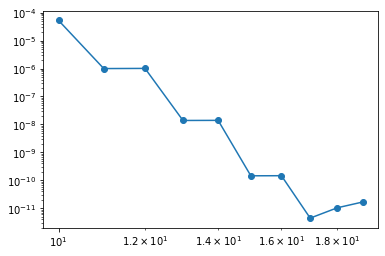

In [33]:
class solution_one_d:
    """
    Description: (callable) Stores the solution to the 1d problem,
    if called returns the solution at that point
    
    Attributes:
        ui (numpy array) : basis coefficients
        vi (list) : list of callable basis functions
        
    Methods:
        __call__(x) : Evaluates the solution at the given points
    """
    def __init__(self, ui, vi):
        """
        Class constructor
        
        Parameters:
            ui (1d numpy array) : basis coefficients
            vi (list) : list of callable basis functions
        """
        self.ui = np.array(ui)
        self.vi = vi
        self.n_basis = len(vi)
    
    def __call__(self, x):
        """
        Evaluates the solution at the given points
        
        Parameters:
            x (number or numpy array) : Points to evaluate the solution at
        
        Returns:
            solution (number or numpy array) : evaluated solution
        """
        vx = np.array([v(x) for v in self.vi]).reshape((self.n_basis, -1))
        
        # for each i
        # u(x_i) = v_j(x_i)*u_j
        res = np.einsum('ji, j -> i', vx, self.ui)
        return res

# Exact solution
def exact_one_d(x):
    return np.cos(np.pi*x)

# Rhs of the problem
def rhs_one_d(x):
    return np.cos(np.pi*x)*(1+np.pi**2)

def solve_one_d(n, rhs):
    """
    Solves the 1d problem using chebyshev finite elements
    
    Parameters:
        n (int): number of finite elements to use
        rhs (callable): rhs function of the problem
    Returns:
        solution_one_d (object, callable): solution of the problem, can be
        called to evaluate it
    """
    # Get the basis functions
    vi = constuct_lagrange_one_d(n)
    # Get the problem matrix
    _, _, A = compute_one_dimensional_matrices(n)
    
    # Compute rhs of the problem
    qa, wa = np.polynomial.legendre.leggauss(n)
    fi = np.array([np.sum(rhs(qa)*v(qa)*wa) for v in vi])
    
    # Solve it
    ui = linalg.solve(A, fi, sym_pos=True)
    return solution_one_d(ui, vi)

def compute_error_one_d(n, exact, rhs):
    """
    Computes the error of the solution using L2 norm
    
    Parameters:
        n (int): number of finite elements to use
        exact (callable): exact solution of the problem
        rhs (callable): rhs function of the problem
    """
    # Compute solution
    solution = solve_one_d(n, rhs)
    
    # Create L2 error function
    loss = lambda x: (exact(x) - solution(x))**2
    
    # Integrate it, I use quad from scipy to avoid integration errors
    error = quad(loss, -1, 1)[0]
    return np.sqrt(error)


error = []
all_n = range(10, 20)
for n in all_n:
    error.append(compute_error_one_d(n, exact_one_d, rhs_one_d))

pl.loglog(all_n, error, 'o-')

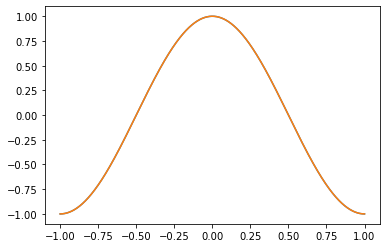

In [5]:
# Plot of the computed solution and the exact one
# The two functions overlap

n = 10
x = np.linspace(-1, 1, 1025)
solution = solve_one_d(n, rhs_one_d)
pl.plot(x, solution(x))
pl.plot(x, exact_one_d(x))

### 3. Two dimensional matrices

Write a function that, given the number of Chebishev points `n` per each coordinate direction, returns `K`, `M`, and `A` for a two dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points (as matrices, i.e., reshaped to be two dimensional)

In [37]:
def compute_two_dimensional_matrices(n):
    # Computes the two dimensional matrices from the one dimensional ones
    K, M, _ = compute_one_dimensional_matrices(n)
    KM = np.einsum('ik, jl -> ijkl', K, M).reshape((n**2, n**2))
    MK = np.einsum('ik, jl -> ijkl', M, K).reshape((n**2, n**2))
    MM = np.einsum('ik, jl -> ijkl', M, M).reshape((n**2, n**2))
    KK = KM+MK
    AA = KK+MM
    
    return KK, MM, AA

### 3. Error in two dimension

Using 

$
u_{exact}(x) = \cos(\pi x_0)\cos(\pi x_1)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

A solution should look like:

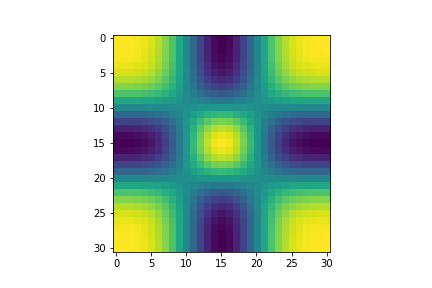

The plot was obtained as `imshow(u.reshape((n,n))`.

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

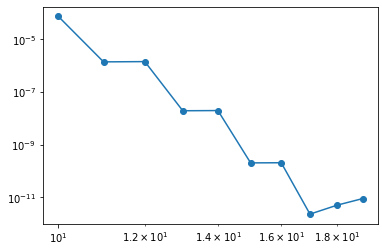

In [88]:
class solution_two_d:
    """
    Description: (callable) Stores the solution to the 2d problem,
    if called returns the solution at that point
    
    Attributes:
        ui (numpy array) : basis coefficients
        vi (list) : list of callable basis functions
        
    Methods:
        __call__(x) : Evaluates the solution at the given points
    """
    def __init__(self, ui, vi):
        """
        Class constructor
        
        Parameters:
            ui (2d numpy array) : basis coefficients
            vi (list) : list of callable basis functions
        """
        self.ui = np.array(ui)
        self.vi = vi
        self.n_basis = len(vi)
    
    def __call__(self, x0, x1):
        """
        Evaluates the solution at the given points
        
        Parameters:
            x0 (number or numpy array) : First coordinate points to evaluate the solution at
            x1 (number or numpy array) : Second coordinate points to evaluate the solution at
            
        Returns:
            solution (number or 2d numpy array) : evaluated solution
        """
        x0 = np.array(x0)
        x1 = np.array(x1)
        vx = np.array([v(x0) for v in self.vi]).reshape(self.n_basis, -1)
        vy = np.array([v(x1) for v in self.vi]).reshape(self.n_basis, -1)
        
        # For each i:
        # v_kl = v_k(x_i) *  v_l(y_i)
        # res = u_i =  u_kl * v_kl
        res = np.einsum('ki, kl, li -> i', vx, self.ui, vy, optimize=True)
        return res.reshape(x0.shape)

# Exact solution
def exact_two_d(x0, x1):
    return np.cos(np.pi*x0)*np.cos(np.pi*x1)

# Rhs of the problem
def rhs_two_d(x0, x1):
    return np.cos(np.pi*x0)*np.cos(np.pi*x1) * (1+2*np.pi**2)

def get_rhs(vi, rhs):
    """
    Computes the rhs of the linear system
    
    Parameters:
        vi (list): list of basis functions
        rhs (callable): rhs function of the problem
    """
    
    n = len(vi)
    qa, wa = np.polynomial.legendre.leggauss(n)
    
    # Evaluate rhs and basis functions
    rhs_eval = rhs(*np.meshgrid(qa, qa))
    vi_eval = np.array([v(qa) for v in vi])
    
    # For each i, j:
    # u_kl = u(q_k, q_l) = v_i(q_k) * rhs(q_k, q_l) * v_j(q_l)
    # res_ij = rhs_ij =  w_k * u_kl * w_l
    res = np.einsum('ik, k, kl, l, jl -> ij', vi_eval, wa, rhs_eval, wa, vi_eval, optimize=True)
    return res
    
def solve_two_d(n, rhs):
    """
    Solves the 2d problem using chebyshev finite elements
    
    Parameters:
        n (int): number of finite elements to use in each dimension
        rhs (callable): rhs function of the problem
    Returns:
        solution_two_d (object, callable): solution of the problem, can be
        called to evaluate it
    """
    # Compute the basis functions
    vi = constuct_lagrange_one_d(n)
    # Get two dimensional matrix
    _, _, A = compute_two_dimensional_matrices(n)
    
    # Calculate rhs
    fij = get_rhs(vi, rhs)
    
    # Solve it
    ui = linalg.solve(A, fij.reshape((n**2)), sym_pos=True)
    return solution_two_d(ui.reshape(n, n), vi)


def compute_error_two_d(n, exact, rhs, matvec=None):
    """
    Computes the error of the solution using L2 norm
    
    Parameters:
        n (int): number of finite elements to use
        exact (callable): exact solution of the problem
        rhs (callable): rhs function of the problem
    """
    # Compute solution
    if matvec is None:
        solution = solve_two_d(n, rhs)
    else:
        solution = solve_two_d_cg(n, rhs, matvec)
    
    # Create L2 error function
    loss = lambda x0, x1: (exact(x0, x1) - solution(x0, x1))**2
    
    # Integrate it, I use dblquad from scipy to avoid integration errors
    error = dblquad(loss, -1, 1, lambda x: -1, lambda x: 1)[0]
    return np.sqrt(error)

error = []
all_n = range(10, 20)
for n in all_n:
    error.append(compute_error_two_d(n, exact_two_d, rhs_two_d))
    print("done: ", n)

clear_output()
pl.loglog(all_n, error, 'o-')

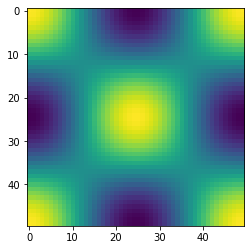

In [8]:
# Plot of the computed solution
solution = solve_two_d(10, rhs_two_d)
x = np.linspace(-1, 1, 50)
pl.imshow(solution(*np.meshgrid(x, x)))

In [89]:
# THE MAJORITY OF THE TIME IS LOST WHEN CONSTRUCTING THE LAGRANGE BASIS
# IF WE RERUN THE SCRIPT WE SEE THAT THE CACHE IS WORKING WELL
%load_ext line_profiler

%lprun -f solve_two_d solve_two_d(30, rhs_two_d)
#%timeit solve_two_d(40, rhs_two_d)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-07 s

Total time: 0.0411514 s
File: <ipython-input-88-f0875bebf227>
Function: solve_two_d at line 77

Line #      Hits         Time  Per Hit   % Time  Line Contents
    77                                           def solve_two_d(n, rhs):
    78                                               """
    79                                               Solves the 2d problem using chebyshev finite elements
    80                                               
    81                                               Parameters:
    82                                                   n (int): number of finite elements to use in each dimension
    83                                                   rhs (callable): rhs function of the problem
    84                                               Returns:
    85                                                   solution_two_d (object, callable): solution of the problem, can be
    86                                                   ca

### 4. Conjugate gradient

The conjugate gradient method does not require the knowledge of the matrix, but only of the result of the matrix vector product with the system matrix A. 

Implement a version of the conjugate gradient method that solves the linear system of the two dimensional problem (up to a given tolerance) by only using a function that implements the matrix vector product, i.e., given a `matvec` function, for example defined by  

~~~
def matvec(src):
    return A.dot(src)
~~~

build a conjugate gradient method that only uses the function `matvec` to evaluate `A.dot(src)`. 

In [90]:
def cg(matvec, b, x0, tol=1e-05, maxiter=10000):
    """
    Solves a linear system using the conjugate gradient method
    
    Parameters:
        matvec (callable) : function to evaluate the matrix vector
        b (numpy array) : rhs of the system
        x0 (numpy array) : Initial guess of the solution
        tol (double) : Relative tolerance when to stop the iteration default=1e-5
        maxiter (int) : Maximum number of iteration default=10000
    Returns:
        x (numpy array) : Converged solution
    """ 
    x = x0.copy()
    r = b - matvec(x)
    p = r.copy()
    
    i = 0
    c = 1 / linalg.norm(b, 2) # Constant to get the relative error
    error = linalg.norm(r, 2) * c
    while(error > tol and i < maxiter):
        a = (p@r) / (p@matvec(p))
        x = x + a*p
        r = r - a*matvec(p)
        b = (matvec(p)@r) / (matvec(p)@p)
        p = r - b*p
        error = linalg.norm(r, 2) * c
        i += 1
    #if(error > tol):
    #    message = f"""Reached maximum number of iterations: {maxiter} error:
    #    {error} is bigger than tol: " {tol} try increasing the number of 
    #    iterations or lowering the tolerance"""
    #    warnings.warn(message)
    return x

### 5. "Matrix free" evaluation

Instead of assembling the two (or three dimensional) matrix, and then compute the matrix vector product using `A.dot(v)`, we can exploit the tensor product structure of the problem, and gain some computational time.

In particular, we exploit the fact that the two dimensional matrix is a `reshape` of the array

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which is constructed using the one dimensional matrices assembled at step 1.

Given an array `v`, it can be reshaped to a matrix of coefficients $v_{ij}$ in $R^{n\times n}$, and we can compute `A.dot(v)` as the sum $w_{ij} = \sum_{kl} A_{ij,kl} v_{kl}$

So `A.dot(v)` reduces to  series of one dimensional matrix-matrix and matrix vector products:


$
w_{ij}  = \sum_{kl} A_{ij,kl} v_{kl} = \sum_{kl} (K_{ik}M_{jl}v_{kl} + M_{ik}K_{jl}v_{kl} + M_{ik}M_{jl}v_{kl})
$

which can be rearranged as 

~~~
def matvec(vinput):
    v = vinput.reshape((n,n))

    Mv = M.dot(v) # result is n x n 
    Kv = K.dot(v) # result is n x n 

    # KT_Mv = K.dot(Mv)  # K is symmetric
    # MT_Kv = M.dot(Kv)  # M is symmetric
    # MT_Mv = M.dot(Mv)  # M is symmetric

    u = K.dot(Mv)
    u += M.dot(Kv) 
    u += M.dot(Mv)
    return u.reshape((n**2,))
~~~

Make a comparison of the timings between using the full two dimensional matrix `A` to compute the matrix vector product, VS using the compressed version above, as we increase `n` from 50 to 100.

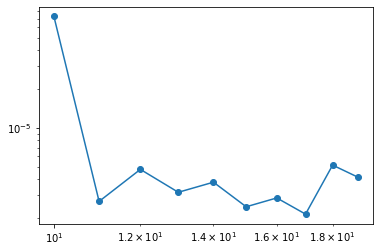

In [113]:
class matvec_two_d():
    """
    Description: (callable) Matrix vector product for the two dimensional problem
    
    Attributes:
        n (int) : number of chebyshev spectral elements
        K (2d numpy array) : 1d Stiffness matrix
        M (2d numpy array) : 1d Mass matrix
        
    Methods:
        __call__(x) : Evaluates the matrix vector product of x
    """
    
    def __init__(self, n):
        """
        Class constructor
        
        Parameters:
            n (int) : number of chebyshev spectral elements
        """
        self.n = n
        self.K, self.M, _ = compute_one_dimensional_matrices(n)
    
    def __call__(self, vinput):
        """
        Evaluates the matrix vector product of x
        
        Parameters:
            vinput (numpy array) : vector to multiply
            
        Returns:
            result (numpy array) : Result of the multiplication A@x     
        """
        v = vinput.reshape((self.n, self.n, -1))
        u = np.einsum("ik, klm, jl -> ijm", self.K, v, self.M, optimize=True)
        u += np.einsum("ik, klm, jl -> ijm", self.M, v, self.K, optimize=True)
        u += np.einsum("ik, klm, jl -> ijm", self.M, v, self.M, optimize=True)
        #v = vinput.reshape((self.n, self.n))
        #u = self.K@v@(self.M).T
        #u += self.M@v@(self.K).T 
        #u += self.M@v@(self.M).T
        return np.squeeze(u.reshape((self.n**2, -1)))
    
    
def solve_two_d_cg(n, rhs, matvec):
    """
    Solves the above problem using chebyshev finite elements
    
    Parameters:
        n (int): number of finite elements to use
        rhs (callable): rhs function of the problem
    Returns:
        solution_one_d (object, callable): solution of the problem, can be
        called to evaluate it
    """
    vi = constuct_lagrange_one_d(n)
    # Find rhs of the system
    fij = get_rhs(vi, rhs)
    
    # Solve it
    x0 = np.random.uniform(0, 1, n**2)
    ui = cg(matvec, fij.reshape((n**2)), x0)
    return solution_two_d(ui.reshape(n, n), vi)

error = []
all_n = list(range(10, 20))
for n in all_n:
    matvec = matvec_two_d(n)
    error.append(compute_error_two_d(n, exact_two_d, rhs_two_d, matvec))
    print("done", n)

clear_output()
pl.loglog(all_n, error, 'o-')

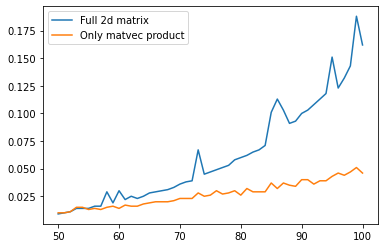

In [119]:
import time

all_n = list(range(50, 101))
time_standard = []
time_compressed = []

for n in all_n:
    x = np.random.uniform(-1, 1, (n**2, 100))
    
    _, _, A = compute_two_dimensional_matrices(n)
    start = time.time()
    A.dot(x)
    time_standard.append(time.time() - start)
    
    matvec = matvec_two_d(n)
    start = time.time()
    matvec(x)
    time_compressed.append(time.time() - start)
    
    print("done:", n, "time compressed:", time_compressed[-1], "time standard:", time_standard[-1])

clear_output()
pl.plot(all_n, time_standard, label="Full 2d matrix")
pl.plot(all_n, time_compressed, label="Only matvec product")
pl.legend()

### 6. "Matrix free" evaluation for three dimensional problems (mandatory for MHPC, optional for others)

Looking at https://www.geeksforgeeks.org/running-python-script-on-gpu/, implement the same matrix free solver for three dimensional problems, exploiting just in time compilation, numba, and (optionally) GPU acceleration (if you have access to a GPU). 

Compare the timings you get for a fixed number of matrix vector products as n increases from 50 to 100 for the cases 

1. matrix based (assemble the three dimensional A, measure time of 100 A.dot(v)
2. matrix free, pure numpy (using techinque above, measure time 100 applications of matvec(v))
3. matrix free, numba+jit on CPU (measure time 100 applications of matvec(v))
4. (optional) matrix free, numba+jit on GPU (measure time 100 applications of matvec(v))

Comment on your findings.